In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pprint as pp

import json
import os
import timeit
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR, SVR, SVC
from sklearn import svm


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/DataScience/horsesDataPointVirg.csv", index_col=False, sep=";")
df.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (31,32,47,48,57,58) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,raceId,horse_name,horse_pmuName,horse_genyName,horse_genyId,horse_canalturfName,horse_canalturfId,hasSulky,age,partantNum,breed,sex,blinkers,ownerName,trainer_name,trainer_pmuName,trainer_genyName,trainer_canalturfId,trainer_canalturfName,raiserName,allure,horseshoe,jockey_name,jockey_pmuName,jockey_genyName,jockey_canalturfName,jockey_canalturfId,robe,weight,musique,pregnant,stats_firstRace,stats_numberRaces,stats_wonRaces,stats_places,stats_secondPlaces,stats_thirdPlaces,stats_earnMoneyTotal,stats_earnMoneyFirst,...,odds_pmu_chronological_3_epoch,odds_pmu_chronological_4_ratio,odds_pmu_chronological_4_epoch,odds_pmu_chronological_5_ratio,odds_pmu_chronological_5_epoch,odds_pmu_chronological_6_ratio,odds_pmu_chronological_6_epoch,odds_pmu_chronological_7_ratio,odds_pmu_chronological_7_epoch,odds_pmu_chronological_8_ratio,odds_pmu_chronological_8_epoch,odds_pmu_chronological_9_ratio,odds_pmu_chronological_9_epoch,odds_pmu_chronological_10_ratio,odds_pmu_chronological_10_epoch,odds_pmu_chronological_11_ratio,odds_pmu_chronological_11_epoch,odds_geny_lastDirect_ratio,odds_betclic_lastDirect_ratio,odds_unibet_lastDirect_ratio,casaques_0_url,casaques_1_url,moneyWon,results_position,results_totalTimeMs,results_kmReducedMs,ropePlace,handicapValue,pedigree_fatherMother,results_distancePrevHorse,weightBefore,rateReclamation,casaques_2_url,casaques_2_y,casaques_2_width,casaques_2_height,odds_zeturf_lastDirect_ratio,casaques_1_y,casaques_1_width,casaques_1_height
0,0,pmu_race:01012017/R1/C10,CALIE DU TROT,CALIE DU TROT,CALIE DU TROT,2421081,CALIE DU TROT,186969.0,False,5,1,TROTTEUR FRANCAIS,F,NONE,N. QUITTET,F. QUITTET,F. QUITTET,Fabrice Quittet,15316.0,F. QUITTET,M. Patrick Germain PIQUET,TROT,ALL,A. DABOUIS,A. DABOUIS,Antoine Dabouis,A. DABOUIS,14016.0,020_BAI,570.0,Da8aDaDaDaDm2a6aDa8a,False,False,32.0,1.0,9.0,1.0,0.0,1367000.0,540000.0,...,1.483286e+12,23.0,1.483287e+12,23.0,1.483287e+12,24.0,1.483288e+12,25.0,1.483288e+12,28.0,1.483289e+12,27.0,1.483290e+12,28.0,1.483290e+12,62.0,1.483291e+12,28.0,34.4,46.1,https://turfinfo.pmucdn.fr/casaques/01012017/R...,https://media.genybet.fr/web/image/casaque/72/...,13670.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,pmu_race:01012017/R1/C10,COLANIE,COLANIE,COLANIE,2449264,COLANIE,198594.0,False,5,2,TROTTEUR FRANCAIS,F,NONE,Ecurie Sébastien HARDY,S. HARDY,S. HARDY,Sébastien Hardy,745.0,S. HARDY,Mme Annie FERRON,TROT,NONE,MLLE NOEMIE HARDY,MLLE NOEMIE HARDY,Mlle Noémie Hardy,MLLE N. HARDY,14830.0,020_BAI,550.0,0a8m0a4m4mDa6aDm9a5a,False,False,25.0,1.0,11.0,0.0,2.0,1400000.0,540000.0,...,1.483286e+12,27.0,1.483287e+12,27.0,1.483287e+12,27.0,1.483288e+12,28.0,1.483288e+12,27.0,1.483289e+12,25.0,1.483290e+12,27.0,1.483290e+12,49.0,1.483291e+12,33.0,24.5,24.4,https://turfinfo.pmucdn.fr/casaques/01012017/R...,https://media.genybet.fr/web/image/casaque/29/...,14000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,pmu_race:01012017/R1/C10,CHARMANTE LULU,CHARMANTE LULU,CHARMANTE LULU,2433769,CHARMANTE LULU,192881.0,False,5,3,TROTTEUR FRANCAIS,F,NONE,Michaël CHARLES,V. BRAZON,V. BRAZON,Vincent Brazon,1454.0,A. PACARY,M. Arnaud CHARLES,TROT,ALL,MLLE AUDREY LAROCHE,MLLE AUDREY LAROCHE,Mlle Audrey Laroche,MLLE A. LAROCHE,10672.0,001_ALEZAN,570.0,7m7a8a8a7a0a2a4a4a9a,False,False,23.0,0.0,14.0,2.0,2.0,1996000.0,0.0,...,1.483286e+12,17.0,1.483287e+12,17.0,1.483287e+12,17.0,1.483288e+12,19.0,1.483288e+12,21.0,1.483289e+12,21.0,1.483290e+12,23.0,1.483290e+12,51.0,1.483291e+12,50.0,27.3,37.7,https://turfinfo.pmucdn.fr/casaques/01012017/R...,https://media.genybet.fr/web/image/casaque/94/...,19960.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,pmu_race:01012017/R1/C10,CAQUISE DE NGANDA,CAQUISE DE NGANDA,CAQUISE DE NGANDA,2480332,CAQUISE DE NGANDA,215352.0,False,5,4,TROTTEUR FRANCAIS,F,NONE,Ecurie Sébastien HARDY,S. HARDY,S. HARDY,Sébastien Hardy,745.0,M. VARIN,M. Hubert CHRISTOPHE,TROT,NONE,D. DULONG,D. DULONG,Dylan Dulong

Pour étudier l'influence des cotes sur la position d'un cheval, nous allons prendre la projection de la dataframe sur les attributs concernants les cotes de pmu (ainsi que sur quelques données évidemment importantes).

In [ ]:
colFilter = ["raceId", "horse_pmuName", "results_position", "results_totalTimeMs"] + [col for col in df if col.startswith("odds_pmu")]
dfCotes = df[colFilter]
dfCotes.shape
dfCotes.head()

,raceId,horse_pmuName,results_position,results_totalTimeMs,odds_pmu_lastDirect_typeBet,odds_pmu_lastDirect_ratio,odds_pmu_lastDirect_typeRatio,odds_pmu_lastDirect_tendancyNumber,odds_pmu_lastDirect_epochMs,odds_pmu_lastDirect_permutation,odds_pmu_lastDirect_favorite,odds_pmu_lastDirect_grossePrise,odds_pmu_lastReference_typeBet,odds_pmu_lastReference_ratio,odds_pmu_lastReference_typeRatio,odds_pmu_lastReference_tendancyNumber,odds_pmu_lastReference_epochMs,odds_pmu_lastReference_permutation,odds_pmu_lastReference_favorite,odds_pmu_lastReference_grossePrise,odds_pmu_reference10h_ratio,odds_pmu_chronological_0_ratio,odds_pmu_chronological_0_epoch,odds_pmu_chronological_1_ratio,odds_pmu_chronological_1_epoch,odds_pmu_chronological_2_ratio,odds_pmu_chronological_2_epoch,odds_pmu_chronological_3_ratio,odds_pmu_chronological_3_epoch,odds_pmu_chronological_4_ratio,odds_pmu_chronological_4_epoch,odds_pmu_chronological_5_ratio,odds_pmu_chronological_5_epoch,odds_pmu_chronological_6_ratio,odds_pmu_chronological_6_epoch,odds_pmu_chronological_7_ratio,odds_pmu_chronological_7_epoch,odds_pmu_chronological_8_ratio,odds_pmu_chronological_8_epoch,odds_pmu_chronological_9_ratio,odds_pmu_chronological_9_epoch,odds_pmu_chronological_10_ratio,odds_pmu_chronological_10_epoch,odds_pmu_chronological_11_ratio,odds_pmu_chronological_11_epoch
0,pmu_race:01012017/R1/C10,CALIE DU TROT,NaN,NaN,PMU_E_SIMPLE_GAGNANT,60.0,DIRECT,0.0,1.483291e+12,1.0,False,False,PMU_E_SIMPLE_GAGNANT,28.0,REFERENCE,2.90,1.483289e+12,1.0,False,False,28.0,22.0,1.483284e+12,22.0,1.483285e+12,22.0,1.483286e+12,23.0,1.483286e+12,23.0,1.483287e+12,23.0,1.483287e+12,24.0,1.483288e+12,25.0,1.483288e+12,28.0,1.483289e+12,27.0,1.483290e+12,28.0,1.483290e+12,62.0,1.483291e+12
1,pmu_race:01012017/R1/C10,COLANIE,NaN,NaN,PMU_E_SIMPLE_GAGNANT,41.0,DIRECT,0.0,1.483291e+12,1.0,False,False,PMU_E_SIMPLE_GAGNANT,18.0,REFERENCE,3.38,1.483289e+12,1.0,False,False,24.0,28.0,1.483284e+12,28.0,1.483285e+12,27.0,1.483286e+12,27.0,1.483286e+12,27.0,1.483287e+12,27.0,1.483287e+12,27.0,1.483288e+12,28.0,1.483288e+12,27.0,1.483289e+12,25.0,1.483290e+12,27.0,1.483290e+12,49.0,1.483291e+12
2,pmu_race:01012017/R1/C10,CHARMANTE LULU,NaN,NaN,PMU_E_SIMPLE_GAGNANT,39.0,DIRECT,0.0,1.483291e+12,1.0,False,False,PMU_E_SIMPLE_GAGNANT,22.0,REFERENCE,0.88,1.483289e+12,1.0,False,False,22.0,17.0,1.483284e+12,17.0,1.483285e+12,17.0,1.483286e+12,17.0,1.483286e+12,17.0,1.483287e+12,17.0,1.483287e+12,17.0,1.483288e+12,19.0,1.483288e+12,21.0,1.483289e+12,21.0,1.483290e+12,23.0,1.483290e+12,51.0,1.483291e+12
3,pmu_race:01012017/R1/C10,CAQUISE DE NGANDA,1.0,218900.0,PMU_E_SIMPLE_GAGNANT,19.0,DIRECT,0.0,1.483291e+12,1.0,False,False,PMU_E_SIMPLE_GAGNANT,16.0,REFERENCE,2.42,1.483289e+12,1.0,False,False,19.0,21.0,1.483284e+12,21.0,1.483285e+12,21.0,1.483286e+12,20.0,1.483286e+12,21.0,1.483287e+12,21.0,1.483287e+12,21.0,1.483288e+12,17.0,1.483288e+12,18.0,1.483289e+12,18.0,1.483290e+12,20.0,1.483290e+12,25.0,1.483291e+12
4,pmu_race:01012017/R1/C10,CATOWICE DE CLECY,4.0,220380.0,PMU_E_SIMPLE_GAGNANT,23.0,DIRECT,0.0,1.483291e+12,1.0,False,False,PMU_E_SIMPLE_GAGNANT,14.0,REFERENCE,2.94,1.483289e+12,1.0,False,False,10.0,8.8,1.483284e+12,8.8,1.483285e+12,8.7,1.483286e+12,8.8,1.483286e+12,8.9,1.483287e+12,9.0,1.483287e+12,9.3,1.483288e+12,9.6,1.483288e+12,10.0,1.483289e+12,10.0,1.483290e+12,12.0,1.483290e+12,16.0,1.483291e+12


On regarde d'abord les distributions des données

In [ ]:
def cutName(word):
    word = word.replace("results_", "")
    word = word.replace("odds_pmu_", "")
    word = word.replace("Ms", "")
    word = word.replace("chronological", "chrono")
    return(word)

dfCotes.rename(cutName, axis="columns", inplace=True)
print(dfCotes.columns)

Index(['raceId', 'horse_pmuName', 'position', 'totalTime',
       'lastDirect_typeBet', 'lastDirect_ratio', 'lastDirect_typeRatio',
       'lastDirect_tendancyNumber', 'lastDirect_epoch',
       'lastDirect_permutation', 'lastDirect_favorite',
       'lastDirect_grossePrise', 'lastReference_typeBet',
       'lastReference_ratio', 'lastReference_typeRatio',
       'lastReference_tendancyNumber', 'lastReference_epoch',
       'lastReference_permutation', 'lastReference_favorite',
       'lastReference_grossePrise', 'reference10h_ratio', 'chrono_0_ratio',
       'chrono_0_epoch', 'chrono_1_ratio', 'chrono_1_epoch', 'chrono_2_ratio',
       'chrono_2_epoch', 'chrono_3_ratio', 'chrono_3_epoch', 'chrono_4_ratio',
       'chrono_4_epoch', 'chrono_5_ratio', 'chrono_5_epoch', 'chrono_6_ratio',
       'chrono_6_epoch', 'chrono_7_ratio', 'chrono_7_epoch', 'chrono_8_ratio',
       'chrono_8_epoch', 'chrono_9_ratio', 'chrono_9_epoch', 'chrono_10_ratio',
       'chrono_10_epoch', 'chrono_11_ratio', 

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
dfCotes[['position', 'totalTime', 'lastDirect_ratio', 'lastDirect_tendancyNumber', 'lastDirect_permutation', 'lastReference_ratio', 'lastReference_tendancyNumber']].describe()

,position,totalTime,lastDirect_ratio,lastDirect_tendancyNumber,lastDirect_permutation,lastReference_ratio,lastReference_tendancyNumber
count,13450.000000,7533.00000,16303.000000,16303.000000,16303.0,15796.000000,15796.000000
mean,5.855539,190919.61901,34.694823,0.028873,1.0,28.383357,1.184676
std,3.472766,38735.75273,46.685438,1.443202,0.0,40.439115,18.246536
min,1.000000,0.00000,1.200000,-49.010000,1.0,1.100000,-94.640000
25%,3.000000,162950.00000,8.200000,0.000000,1.0,8.100000,-2.430000
50%,5.000000,203100.00000,18.000000,0.000000,1.0,15.000000,1.250000
75%,8.000000,219100.00000,41.000000,0.000000,1.0,32.000000,6.252500
max,20.000000,409700.00000,506.000000,45.000000,1.0,813.000000,541.660000


On étudie alors plus précisemment les correlations entre les séries


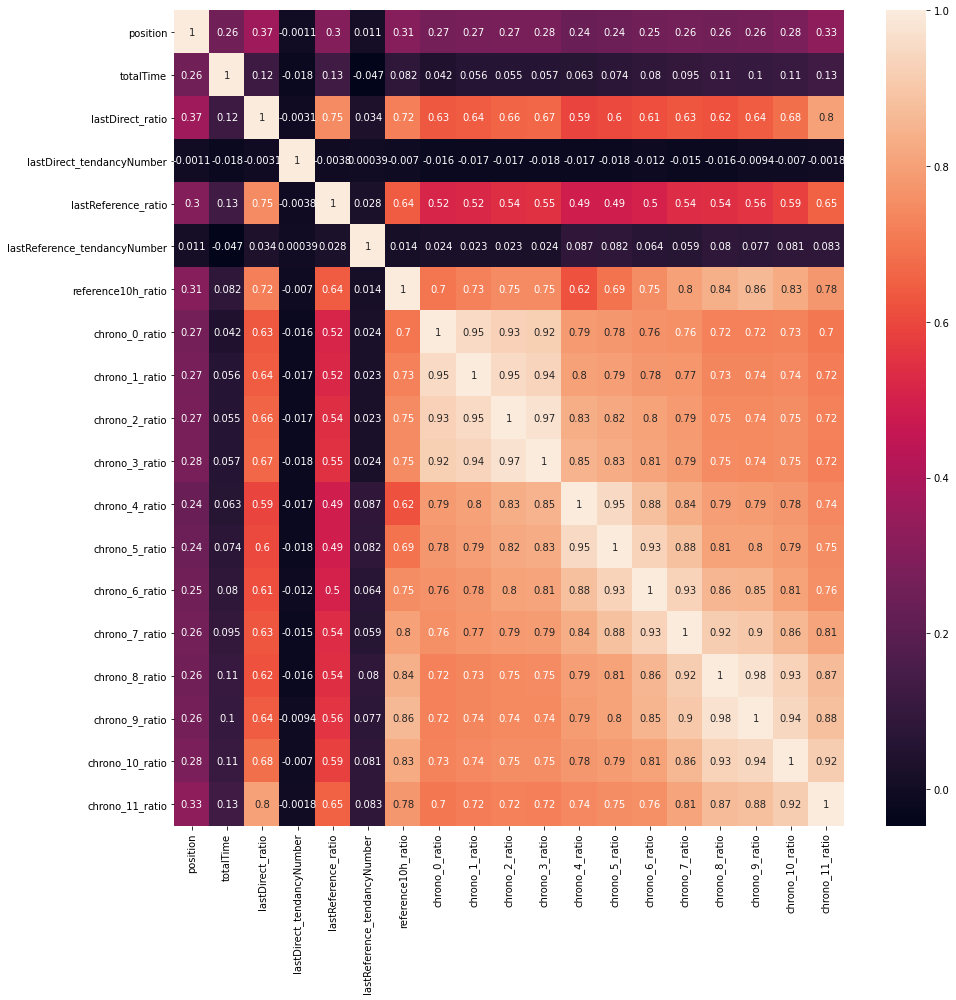

In [ ]:
matCorrelations = dfCotes[[col for col in dfCotes if not col.endswith(('epoch', 'permutation', 'Ms'))]].corr()
fig, ax = plt.subplots(figsize=(15,15))   
sn.heatmap(matCorrelations, annot=True)

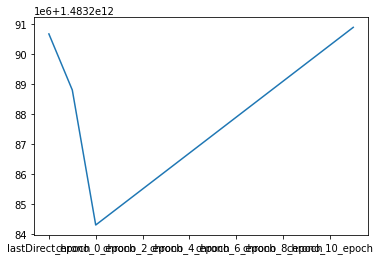

In [ ]:
epochs = [col for col in dfCotes if "epoch" in col]
dfCotesEpochs = dfCotes[epochs]
fig.suptitle('Evolution Temps des epochs')
dfCotesEpochs.iloc[0].plot()


Pour y voir plus clair, nous allons prendre comme de temps de "référence" le temps du premier enregistrement.


In [ ]:
def normalizeTime(temps):
  return(temps-temps[2])

dfCotesEpochs = dfCotesEpochs.apply(normalizeTime, axis=1)

dfCotesEpochs.describe()

,lastDirect_epoch,lastReference_epoch,chrono_0_epoch,chrono_1_epoch,chrono_2_epoch,chrono_3_epoch,chrono_4_epoch,chrono_5_epoch,chrono_6_epoch,chrono_7_epoch,chrono_8_epoch,chrono_9_epoch,chrono_10_epoch,chrono_11_epoch
count,1.604900e+04,1.555400e+04,16328.0,16237.0,15835.0,15583.0,15443.0,15258.0,15169.0,15053.0,14952.0,14797.0,14684.0,14569.0
mean,-1.928459e+06,-3.835764e+06,0.0,600000.0,1200000.0,1800000.0,2400000.0,3000000.0,3600000.0,4200000.0,4800000.0,5400000.0,6000000.0,6600000.0
std,1.327280e+07,1.324190e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,-3.922000e+07,-4.018900e+07,0.0,600000.0,1200000.0,1800000.0,2400000.0,3000000.0,3600000.0,4200000.0,4800000.0,5400000.0,6000000.0,6600000.0
25%,-1.041000e+07,-1.228700e+07,0.0,600000.0,1200000.0,1800000.0,2400000.0,3000000.0,3600000.0,4200000.0,4800000.0,5400000.0,6000000.0,6600000.0
50%,6.249000e+06,4.211000e+06,0.0,600000.0,1200000.0,1800000.0,2400000.0,3000000.0,3600000.0,4200000.0,4800000.0,5400000.0,6000000.0,6600000.0
75%,6.646000e+06,4.513000e+06,0.0,600000.0,1200000.0,1800000.0,2400000.0,3000000.0,3600000.0,4200000.0,4800000.0,5400000.0,6000000.0,6600000.0
max,1.887100e+07,1.680700e+07,0.0,600000.0,1200000.0,1800000.0,2400000.0,3000000.0,3600000.0,4200000.0,4800000.0,5400000.0,6000000.0,6600000.0


Nous cherchons à comprendre les last reference et les last direct.

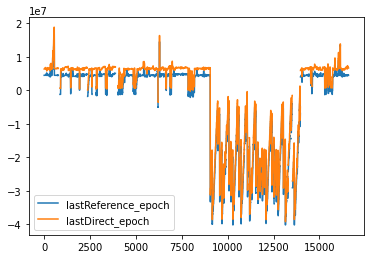

In [ ]:
dfCotesEpochs[['lastReference_epoch', 'lastDirect_epoch']].plot()

In [ ]:
print(dfCotesEpochs[['lastDirect_epoch', 'lastReference_epoch']].corr())
equ = (dfCotesEpochs['lastDirect_epoch'] == dfCotesEpochs['lastReference_epoch'])
print(equ)

                     lastDirect_epoch  lastReference_epoch
lastDirect_epoch             1.000000             0.999609
lastReference_epoch          0.999609             1.000000
0        False
1        False
2        False
3        False
4        False
         ...  
16579    False
16580    False
16581    False
16582    False
16583    False
Length: 16584, dtype: bool
